In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using Roots

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64 
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 8
    A::Int64 = Z + N
    
    # parameters for initial density
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    # parameters for ph interaction
    t₀ = -1800
    x₀ = 0.0
    t₃ = 12871
    x₃ = 0.0
    α = 1/3
    
    # parameters for pp interaction
    tp₀ = -831
    tp₃ = 6*930/0.16^1.2
    αp = 1.2
    
    # radial grids
    Nr::Int64 = 100
    Δr = 0.1
    rs::T = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, R/Δr) + 1
    
    # energy
    Emin = -70.0
    Emax = 0.0
    ΔE = 1.0
    Es::T = range(Emin, Emax, step=ΔE)
    
    # maximal value of angular momentum
    lmax::Int64 = 5
    nstates_max::Int64 = 1000
    
    # potential
    Vs::Vector{Float64} = zeros(Float64, Nr+1)
    λq::Vector{Float64} = zeros(Float64, 2)
    Δq::Vector{Float64} = [12/sqrt(A), 12/sqrt(A)]
    
    # buffer for integrating HF eq.
    ys_p::Vector{Float64} = similar(rs)
    ys_m::Vector{Float64} = similar(rs)
    
    Gs::Vector{Float64} = similar(rs)
    As::Vector{Float64} = similar(rs)
    
    # derivative
    dψ::Vector{Float64} = similar(rs)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1 # q=1 for neutron, q=2 for proton
end

@with_kw struct Densities
    ρ_q::Matrix{Float64}; @assert size(ρ_q, 2) === 2
    τ_q::Matrix{Float64}; @assert size(τ_q, 2) === 2
    ρ_tot::Vector{Float64}
    τ_tot::Vector{Float64}
    
    ρp_q::Matrix{Float64}; @assert size(ρp_q, 2) === 2
    ρp_tot::Vector{Float64}
end

@with_kw struct PairingDensities
    ρp_q::Matrix{Float64}; @assert size(ρp_q, 2) === 2
    ρp_tot::Vector{Float64}
end

@with_kw struct SingleParticleStates
    nstates_max::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates_max
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates_max
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates_max
    occ::Vector{Float64}; @assert length(occ) === nstates_max
    
    Δs::Vector{Float64}; @assert length(Δs) === nstates_max
    λq::Vector{Float64}; @assert length(λq) === 2
end

end # module My

Main.My

In [3]:
function make_states(param)
    @unpack Nr, nstates_max = param 
    
    spEs  = zeros(Float64, nstates_max)
    spEs .= 1e10
    
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr+1, nstates_max)
    occ = zeros(Float64, nstates_max)
    Δs = zeros(Float64, nstates_max)
    λq = zeros(Float64, 2)
    
    My.SingleParticleStates(nstates_max, spEs, qnums, wfs, occ, Δs, λq)
end

make_states (generic function with 1 method)

In [4]:
param = My.PhysicalParam(N=10)

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 10
  A: Int64 18
  r₀: Float64 1.2
  R: Float64 3.1448896730506757
  a: Float64 0.67
  ρ₀: Float64 0.13815533254504805
  t₀: Float64 -1800.0
  x₀: Float64 0.0
  t₃: Float64 12871.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  tp₀: Float64 -831.0
  tp₃: Float64 50314.15921851407
  αp: Float64 1.2
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 32
  Emin: Float64 -70.0
  Emax: Float64 0.0
  ΔE: Float64 1.0
  Es: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  lmax: Int64 5
  nstates_max: Int64 1000
  Vs: Array{Float64}((101,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  λq

In [11]:
function initial_density(param; κ=0.0)
    @unpack A, N, Z, r₀, R, a, ρ₀, rs, Nr = param
    
    ρ_q = zeros(Float64, Nr+1, 2)
    τ_q = zeros(Float64, Nr+1, 2)
    ρ_tot = zeros(Float64, Nr+1)
    τ_tot = zeros(Float64, Nr+1)
    
    ρp_q = zeros(Float64, Nr+1, 2)
    ρp_tot = zeros(Float64, Nr+1)
    
    @. ρ_q[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρ_q[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρ_tot = ρ_q[:,1] + ρ_q[:,2]
    
    @. ρp_q[:,1] = κ*(ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρp_q[:,2] = κ*(ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρp_tot = ρp_q[:,1] + ρp_q[:,2]
    
    return My.Densities(ρ_q, τ_q, ρ_tot, τ_tot, ρp_q, ρp_tot)
end

function test_initial_density(param)
    @unpack rs = param 
    @time dens = initial_density(param; κ=0.1)
    p = plot()
    plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
    plot!(rs, dens.ρ_tot; label="ρ_tot")
    plot!(rs, dens.ρp_q[:,1]; label="ρp_n")
    plot!(rs, dens.ρp_q[:,2]; label="ρp_p")
end

test_initial_density (generic function with 1 method)

  0.000006 seconds (6 allocations: 7.922 KiB)


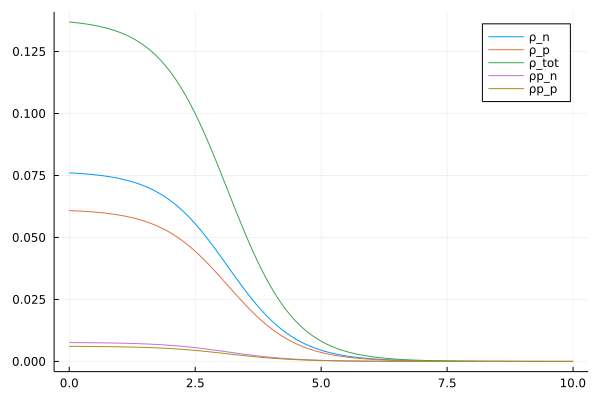

In [12]:
test_initial_density(param)

In [108]:
function calc_potential!(param, dens, qnum)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, rs, Vs = param 
    @unpack ρ_q, ρ_tot, ρp_q, ρp_tot = dens
    @unpack l, j, q = qnum
    
    @views begin
        # t₀ term
        @. Vs  = t₀*((1+0.5x₀)*ρ_tot - (x₀+0.5)*ρ_q[:,q])
        
        # t₃ term
        @. Vs +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρ_tot^(α+1)
        @. Vs += -1/12*t₃*(x₃+0.5)*α*(ρ_tot^(α-1))*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        @. Vs += -1/12*t₃*(x₃+0.5)*2*(ρ_tot^α)*ρ_q[:,q]
        
        # pairing term
        @. Vs += (1/12)*tp₃*(ρ_tot^αp)*ρp_q[:,q]
        
        # centrifugal potential
        @. Vs += M*l*(l+1)/rs^2
    end
end

function test_calc_potential!(param; l=0, κ=0.1)
    @unpack rs, Vs = param
    
    p = plot(; ylim=(-60, 10))
    
    dens = initial_density(param; κ=0.0)
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(param, dens, qnum)
    plot!(p, rs, Vs; label="V_n κ=0.0")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(param, dens, qnum)
    plot!(p, rs, Vs; label="V_p κ=0.0")
    
    dens = initial_density(param; κ=κ)
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(param, dens, qnum)
    plot!(p, rs, Vs; label="V_n κ=$κ")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(param, dens, qnum)
    plot!(p, rs, Vs; label="V_p κ=$κ")
end

test_calc_potential! (generic function with 1 method)

  0.000041 seconds
  0.000038 seconds
  0.000036 seconds
  0.000036 seconds


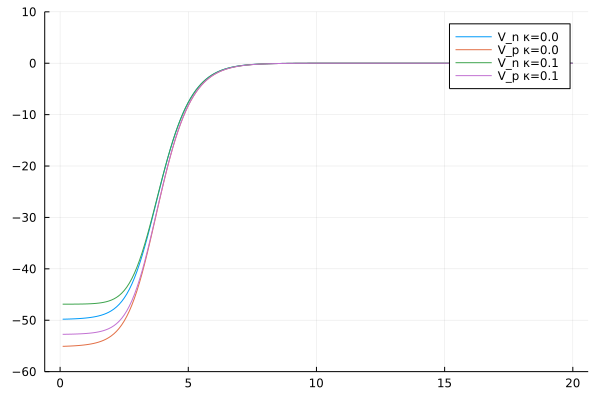

In [111]:
test_calc_potential!(param; l=0, κ=0.1)

In [53]:
function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFeq!(param, E, qnum)
    @unpack M, Nr, Δr, rs, ir_matching, Vs, 
        ys_p, ys_m, Gs, As = param
    
    @unpack l, j, q = qnum
    
    @. As = 1 - (Δr*Δr/12)*(Vs-E)/M
    
    # outward integration
    fill!(ys_p, 0)
    ys_p[1] = 0.0
    ys_p[2] = Δr^(l+1)
    
    if l !== 1
        Gs[1] = 0.0
    else
        Gs[1] = - Δr*Δr/6
    end
    Gs[2] = As[2]*ys_p[2]
    
    for ir in 3:ir_matching+1
        Gs[ir] = 12ys_p[ir-1] - 10Gs[ir-1] - Gs[ir-2]
        ys_p[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_p, rs)
    
    # inward integration 
    fill!(ys_m, 0)
    ys_m[Nr+1] = 0.0
    ys_m[Nr  ] = Δr
    
    Gs[Nr+1] = 0.0
    Gs[Nr  ] = As[Nr]*ys_m[Nr]
    
    for ir in Nr-1: -1: ir_matching-1
        Gs[ir] = 12ys_m[ir+1] - 10Gs[ir+1] - Gs[ir+2]
        ys_m[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_m, rs)
    
    return
end

function test_integrate_HFeq!(param; E=-40.0, l=0, q=1)
    @unpack rs, Nr, Δr, Vs, ys_p, ys_m = param 
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    calc_potential!(param, dens, qnum)
    
    @time integrate_HFeq!(param, E, qnum)
    
    p = plot()
    plot!(rs, ys_p; label="ys_p")
    plot!(rs, ys_m; label="ys_m")
end

test_integrate_HFeq! (generic function with 1 method)

  0.000002 seconds


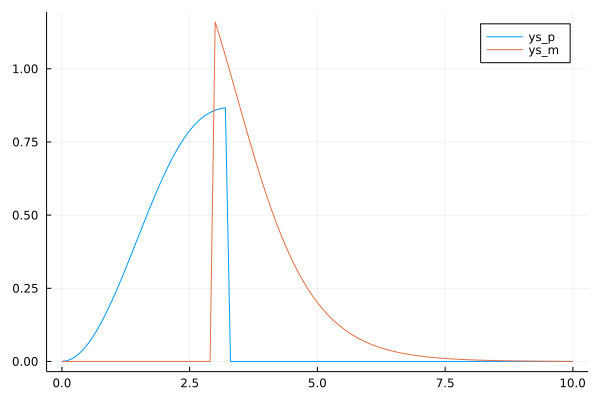

In [54]:
test_integrate_HFeq!(param; E=-30, l=1)

In [55]:
function calc_matching_condition(param)
    @unpack Δr, ir_matching, ys_p, ys_m = param
    
    ir = ir_matching 
    
    a = ys_p[ir]
    b = ys_m[ir]
    c = (ys_p[ir+1] - ys_p[ir-1])/2Δr
    d = (ys_m[ir+1] - ys_m[ir-1])/2Δr
    
    return a*d - b*c
end

calc_matching_condition (generic function with 1 method)

In [56]:
function test_calc_matching_condition(param; l=0, q=1)
    @unpack Nr, rs, Es, Δr, Vs, ys_p, ys_m = param 
    
    fs = similar(Es)
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    calc_potential!(param, dens, qnum)
    
    for iE in 1:length(Es)
        integrate_HFeq!(param, Es[iE], qnum)
        fs[iE] = calc_matching_condition(param)
    end
    
    fs
end

test_calc_matching_condition (generic function with 1 method)

  0.084353 seconds (668.30 k allocations: 35.121 MiB, 99.87% compilation time)


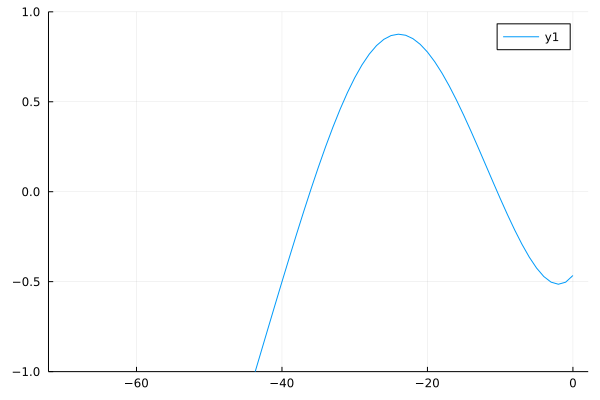

In [57]:
@time fs = test_calc_matching_condition(param; l=0)
plot(param.Es, fs; ylim=(-1,1))

In [191]:
function construct_eigenfunction!(ys, param, E, qnum)
    @unpack Nr, Δr, rs, ir_matching, Vs, ys_p, ys_m = param 
    
    integrate_HFeq!(param, E, qnum)
    
    ratio = ys_p[ir_matching]/ys_m[ir_matching]
    @. ys_m *= ratio 
    
    for ir in 1:ir_matching
        ys[ir] = ys_p[ir]
    end
    for ir in ir_matching+1:Nr+1
        ys[ir] = ys_m[ir]
    end
    
    normalize!(ys, rs)
    
    return
end

function calc_states!(states, param, dens)
    @unpack rs, Es, lmax, Vs = param 
    @unpack spEs, qnums, wfs = states
    
    fill!(spEs, 1e10)
    
    istate = 0
    for l in 0:lmax, q in 1:2
        qnum = My.QuantumNumbers(l=l, q=q)
        calc_potential!(param, dens, qnum)
        
        function f(E)
            integrate_HFeq!(param, E, qnum)
            calc_matching_condition(param)
        end
        
        for i in 1:length(Es)-1
            f₁ = f(Es[i])
            f₂ = f(Es[i+1])

            @views if f₁*f₂ < 0
                E = find_zero(f, (Es[i], Es[i+1]), Bisection())
                istate += 1
                spEs[istate] = E
                qnums[istate] = qnum
                construct_eigenfunction!(wfs[:, istate], param, E, qnum)
            end
        end
    end
end

function sort_states!(states)
    @unpack spEs, qnums, wfs = states
    p = sortperm(spEs)
    wfs[:] = wfs[:,p]
    spEs[:] = spEs[p]
    qnums[:] = qnums[p]
    return 
end

function calc_occ!(states, param)
    @unpack A, Z, N = param
    @unpack nstates_max, spEs, qnums, occ = states
    
    fill!(occ, 0)
    
    n_neutron = 0
    n_proton  = 0
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l, j, q = qnums[i]
        
        if q === 1 # neutron
            if n_neutron + 2(2l+1) ≤ N
                occ[i] = 1
                n_neutron += 2(2l+1)
            elseif n_neutron < N
                occ[i] = (N - n_neutron)/2(2l+1)
                n_neutron = N
            end
        end
        
        if q === 2 # proton
            if n_proton + 2(2l+1) ≤ Z
                occ[i] = 1
                n_proton += 2(2l+1)
            elseif n_proton < Z
                occ[i] = (Z - n_proton)/2(2l+1)
                n_proton = Z
            end
        end
    end
    
    @assert n_neutron === N
    @assert n_proton  === Z
    
    return 
end

function show_states(states)
    @unpack nstates_max, spEs, qnums, occ, Δs = states
    println("")
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        println("i = $i: ")
        @show spEs[i] occ[i] Δs[i] qnums[i]
        println("")
    end
end

show_states (generic function with 1 method)

In [177]:
function test_calc_states!(param)
    @unpack Nr, rs = param 
    
    dens = initial_density(param)
    states = make_states(param)
    
    @time calc_states!(states, param, dens)
    @time sort_states!(states)
    @time calc_occ!(states, param)
    
    show_states(states)
end

test_calc_states! (generic function with 1 method)

In [192]:
param = My.PhysicalParam(N=10,Z=8, Nr=200)
test_calc_states!(param)

  0.036346 seconds (90.97 k allocations: 4.911 MiB, 86.13% compilation time)
  0.000231 seconds (7 allocations: 1.572 MiB)
  0.000001 seconds

i = 1: 
spEs[i] = -40.65423553802491
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -36.12918358830279
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -28.42813213103926
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -24.47679670474214
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -15.168231618751541
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -13.455991420881402
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 7: 
spEs[i] = -11.89785049356

In [61]:
function first_deriv!(dψ, rs, ψ)
    Nr = length(rs)
    Δr = rs[2] - rs[1]
    
    dψ[1] = ψ[2]/2Δr
    for ir in 2:Nr-1
        dψ[ir] = (ψ[ir+1] - ψ[ir-1])/2Δr
    end
    dψ[Nr] = -ψ[Nr-1]/2Δr
    
    return 
end

function calc_density!(dens, param, states)
    @unpack rs, dψ = param
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρ_q, τ_q, ρ_tot, τ_tot = dens
    
    fill!(ρ_q, 0)
    fill!(τ_q, 0)
    @views for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i]
        first_deriv!(dψ, rs, ψ)
        
        @. ρ_q[:,q] += occ[i] * 2(2l+1)/4π * (ψ/rs)^2
        @. τ_q[:,q] += occ[i] * 2(2l+1)/4π * (dψ/rs - ψ/(rs*rs))*(dψ/rs - ψ/(rs*rs))
        @. τ_q[:,q] += occ[i] * 2(2l+1)/4π * l*(l+1)*(ψ/rs^2)^2
    end
    
    @views @. begin
        ρ_q[1,:] = 4ρ_q[2,:] - 6ρ_q[3,:] + 4ρ_q[4,:] - ρ_q[5,:]
        τ_q[1,:] = 4τ_q[2,:] - 6τ_q[3,:] + 4τ_q[4,:] - τ_q[5,:]

        ρ_tot = ρ_q[:,1] + ρ_q[:,2]
        τ_tot = τ_q[:,1] + τ_q[:,2]
    end
end

function test_calc_density(param)
    @unpack Nr, rs = param 
    
    p = plot()
    
    dens = initial_density(param)
    plot!(p, rs, dens.ρ_q[:,1]; label="ρ_n₀")
    plot!(p, rs, dens.ρ_q[:,2]; label="ρ_p₀")
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    
    @time calc_density!(dens, param, states)
    
    plot!(p, rs, dens.ρ_q[:,1]; label="ρ_n")
    plot!(p, rs, dens.τ_q[:,1]; label="τ_n")
    plot!(p, rs, dens.ρ_q[:,2]; label="ρ_p")
    plot!(p, rs, dens.τ_q[:,2]; label="τ_p")
    display(p)
    
end

test_calc_density (generic function with 1 method)

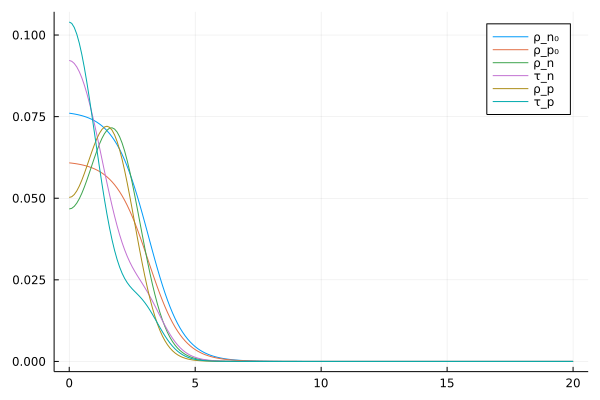

  0.000035 seconds


In [62]:
test_calc_density(param)

In [160]:
function calc_total_energy(param, dens)
    @unpack M, t₀, x₀, t₃, x₃, α, tp₀, tp₃, αp, Δr, Nr, rs = param 
    @unpack ρ_q, τ_q, ρ_tot, τ_tot, ρp_q = dens
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += M*τ_tot

        @. ε += +0.5t₀*(1+0.5x₀)*ρ_tot*ρ_tot
        @. ε += -0.5t₀*(x₀+0.5)*(ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        
        @. ε += +1/12*t₃*(1+0.5x₃)*ρ_tot^(α+2)
        @. ε += -1/12*t₃*(x₃+0.5)*ρ_tot^α*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
        
        # pairing energy
        @. ε += (1/4 )*tp₀*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
        @. ε += (1/24)*tp₃*(ρ_tot^αp)*(ρp_q[:,1]*ρp_q[:,1] + ρp_q[:,2]*ρp_q[:,2])
    end
    
    return sum((@. 4π*rs^2 * ε)) * Δr
end

function calc_total_energy2(param, dens, states)
    @unpack M, t₀, x₀, t₃, x₃, α, Δr, Nr, rs = param 
    @unpack ρ_q, τ_q, ρ_tot, τ_tot = dens
    @unpack nstates_max, spEs, qnums, occ = states
    
    ε = zeros(Float64, Nr+1)
    @views begin
        @. ε += 0.5M*τ_tot
        
        @. ε += -α/24*t₃*(1+0.5x₃)*ρ_tot^(α+2)
        @. ε += +α/24*t₃*(x₃+0.5)*ρ_tot^α*
                    (ρ_q[:,1]*ρ_q[:,1]+ρ_q[:,2]*ρ_q[:,2])
    end
    
    E = sum((@. 4π*rs^2 * ε)) * Δr
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l = qnums[i]
        
        E += 0.5*2(2l+1)*occ[i]*spEs[i]
    end
    
    return E
end


function HF_calc(param; iter_max=10, show_result=false)
    @unpack rs, Δr, Vs = param
    
    dens = initial_density(param)
    states = make_states(param)
    
    Etots  = zeros(Float64, iter_max)
    Etots2 = zeros(Float64, iter_max)
    
    @time for iter in 1:iter_max
        calc_states!(states, param, dens)
        sort_states!(states)
        calc_occ!(states, param)
        
        calc_density!(dens, param, states)
        
        Etots[iter]  = calc_total_energy(param, dens)
        Etots2[iter] = calc_total_energy2(param, dens, states)
    end
    
    E = calc_total_energy(param, dens)
    E₂ = calc_total_energy2(param, dens, states)
    
    if show_result
        @show E E₂
        show_states(states)

        p = plot()
        plot!(Etots; label="Etots", marker=:dot)
        plot!(Etots2; label="Etots2", marker=:dot)
        display(p)

        p = plot()
        plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
        plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
        display(p)
    end
    
end

HF_calc (generic function with 1 method)

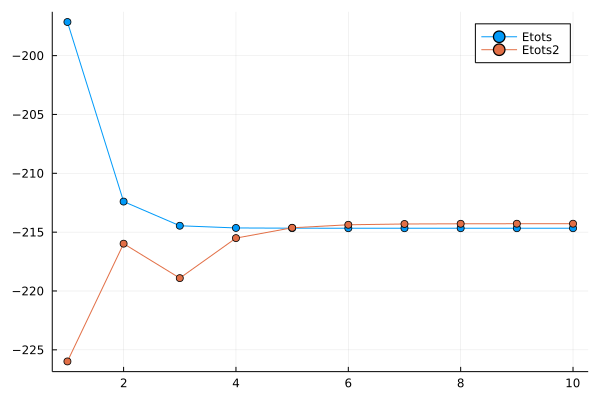

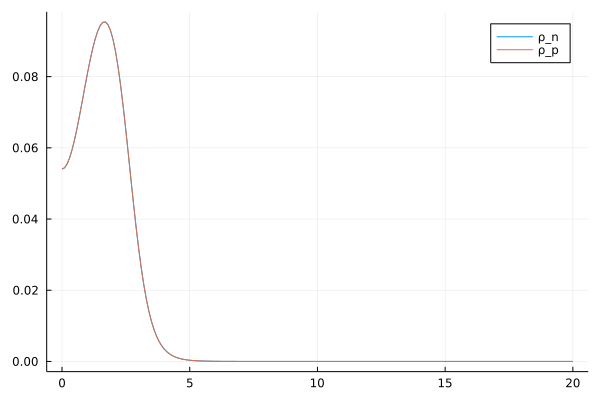

  0.097044 seconds (1.20 k allocations: 16.049 MiB, 15.86% gc time)
E = -214.66700643957938
E₂ = -214.2826486287749

i = 1: 
spEs[i] = -38.07437615979508
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0
Δs[i] = 0.0

i = 2: 
spEs[i] = -38.07437615979508
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 1.0
Δs[i] = 0.0

i = 3: 
spEs[i] = -24.379585606355544
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0
Δs[i] = 0.0

i = 4: 
spEs[i] = -24.379585606355544
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2

occ[i] = 1.0
Δs[i] = 0.0

i = 5: 
spEs[i] = -8.625731236656195
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.2
Δs[i] = 0.0

i = 6: 
spEs[i] = -8.625731236656195
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2

occ[i] = 0.2
Δs[i] = 0.0

i = 7: 
spEs[i] = -5.0428810049000345
qnums[i] = Main.My.Qu

In [185]:
param = My.PhysicalParam(N=10,Z=10, Nr=200)
HF_calc(param; iter_max=10, show_result=true)

# HF+BCS

In [220]:
function calc_pairing_gap!(states, param, dens)
    @unpack Nr, Δr, tp₀, tp₃, αp, Vs = param
    @unpack nstates_max, spEs, qnums, wfs, Δs = states
    @unpack ρ_tot, ρp_q = dens
    
    @. Vs = tp₀ + (1/6)*tp₃*(ρ_tot^αp)
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack q = qnums[i]
        
        #Δs[i] = -0.5*sum((@. Vs*ρp_q[:,q]*wfs[:,i]*wfs[:,i]))*Δr
        Δs[i] = 0.0
        for ir in 1:Nr+1
            Δs[i] += Vs[ir]*ρp_q[ir,q]*wfs[ir,i]*wfs[ir,i]
        end
        Δs[i] *= -0.5Δr
    end
end

function test_calc_pairing_gap!(param)
    dens = initial_density(param; κ=0.3)
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    @time calc_pairing_gap!(states, param, dens)
    
    @unpack spEs, Δs = states
    p = plot()
    plot!(p, Δs[spEs .≠ 1e10])
end

test_calc_pairing_gap! (generic function with 1 method)

  0.000004 seconds


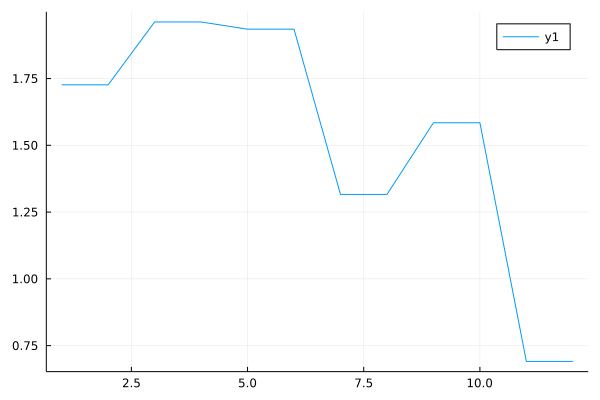

In [221]:
test_calc_pairing_gap!(param)

In [210]:
function calc_particle_number(param, states, q, λ)
    @unpack nstates_max, spEs, qnums, occ, Δs = states
    
    Aq = 0
    
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l = qnums[i]
        
        Δ = Δs[i]
        ε = spEs[i] - λ
        
        if qnums[i].q == q
            Aq += 2(2l+1)*0.5(1 - ε/sqrt(ε*ε + Δ*Δ))
        end
    end
    
    return Aq
end


function calc_chemical_potential!(states, param; λmin=-50, λmax=0.0)
    @unpack A, Z, N = param
    @unpack λq = states
    
    f(λ) = calc_particle_number(param, states, 1, λ) - N
    λq[1] = find_zero(f, (λmin, λmax), Bisection())
    
    g(λ) = calc_particle_number(param, states, 2, λ) - Z
    λq[2] = find_zero(g, (λmin, λmax), Bisection())
    
    return
end

calc_chemical_potential! (generic function with 1 method)

In [211]:
function test_calc_chemical_potential!(param)
    @unpack A = param
    dens = initial_density(param; κ=0.1)
    states = make_states(param)
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    calc_pairing_gap!(states, param, dens)
    
    @time calc_chemical_potential!(states, param)
    @unpack λq = states
    
    N = calc_particle_number(param, states, 1, λq[1])
    Z = calc_particle_number(param, states, 2, λq[2])
    @show λq N Z
    
    return
end

test_calc_chemical_potential! (generic function with 1 method)

In [213]:
test_calc_chemical_potential!(param)

  0.000101 seconds (14 allocations: 4.062 KiB)
λq = [-11.654434416219052, -22.028754685370345]
N = 10.000000000000004
Z = 8.0


In [208]:
function calc_occ_BCS!(states, param)
    @unpack nstates_max, spEs, qnums, occ, Δs, λq = states
    
    fill!(occ, 0)
    for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        
        @unpack l, q = qnums[i]
        
        Δ = Δs[i]
        ε = spEs[i] - λq[q]
        
        occ[i] = 0.5(1 - ε/sqrt(ε*ε + Δ*Δ))
    end
end

function calc_pairing_density!(dens, param, states)
    @unpack rs = param
    @unpack nstates_max, spEs, qnums, wfs, occ = states
    @unpack ρp_q, ρp_tot = dens
    
    fill!(ρp_q, 0)
    @views for i in 1:nstates_max
        if spEs[i] == 1e10
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i] 
        
        uv = sqrt((1 - occ[i])*occ[i])
        
        @. ρp_q[:,q] += 2(2l+1)/4π * uv * (ψ/rs)^2
    end
    
    @views @. begin
        ρp_q[1,:] = 4ρp_q[2,:] - 6ρp_q[3,:] + 4ρp_q[4,:] - ρp_q[5,:]

        ρp_tot = ρp_q[:,1] + ρp_q[:,2]
    end
end

function test_calc_pairing_density!(param)
    @unpack rs = param
    
    dens = initial_density(param; κ=0.3)
    states = make_states(param)
    
    @unpack ρp_q = dens
    p = plot()
    plot!(p, rs, ρp_q[:,1]; label="ρp_n")
    plot!(p, rs, ρp_q[:,2]; label="ρp_p")
    
    calc_states!(states, param, dens)
    sort_states!(states)
    
    calc_pairing_gap!(states, param, dens)
    calc_chemical_potential!(states, param)
    calc_occ_BCS!(states, param)
    
    @time calc_pairing_density!(dens, param, states)
    plot!(p, rs, ρp_q[:,1]; label="ρp_n")
    plot!(p, rs, ρp_q[:,2]; label="ρp_p")
    display(p)
    
    show_states(states)
end

test_calc_pairing_density! (generic function with 1 method)

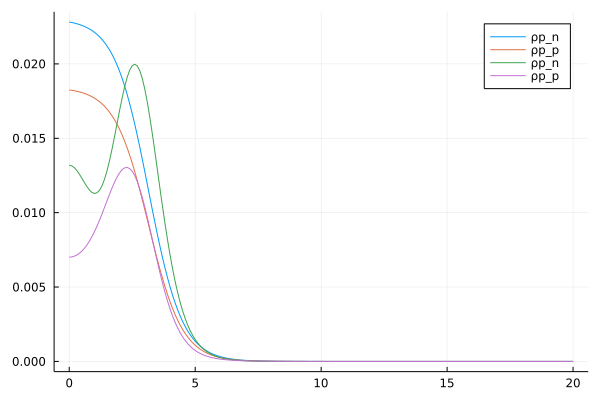

  0.000008 seconds

i = 1: 
spEs[i] = -36.358275411652215
occ[i] = 0.99767874869614
Δs[i] = 1.5522110885230562
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 2: 
spEs[i] = -30.96514196022056
occ[i] = 0.9975091990169653
Δs[i] = 1.9795861346049237
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 3: 
spEs[i] = -25.40404095765765
occ[i] = 0.9725964838340793
Δs[i] = 1.7611804126718225
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 4: 
spEs[i] = -20.93083206302834
occ[i] = 0.9877757243945375
Δs[i] = 2.190589241925513
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 5: 
spEs[i] = -13.186986975891587
occ[i] = 0.014135131755385999
Δs[i] = 1.729607280819829
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 6: 
spEs[i] = -10.992860274565023
occ[i] = 0.004056822733366827
Δs[i] = 1.1936107306206374
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j

In [214]:
test_calc_pairing_density!(param)

In [217]:
function HFBCS_calc(param; iter_max=10, κ=0.3, show_result=false)
    @unpack rs, Δr, Vs = param
    
    dens = initial_density(param; κ=κ)
    states = make_states(param)
    
    Etots  = zeros(Float64, iter_max)
    Etots2 = zeros(Float64, iter_max)
    
    @time for iter in 1:iter_max
        calc_states!(states, param, dens)
        sort_states!(states)

        calc_pairing_gap!(states, param, dens)
        calc_chemical_potential!(states, param)
        calc_occ_BCS!(states, param)
        
        calc_density!(dens, param, states)
        calc_pairing_density!(dens, param, states)
        
        Etots[iter] = calc_total_energy(param, dens)
    end
    
    E = calc_total_energy(param, dens)
    
    if show_result
        @show E 
        
        show_states(states)

        p = plot()
        plot!(Etots; label="Etots", marker=:dot)
        display(p)

        p = plot()
        plot!(rs, dens.ρ_q[:,1]; label="ρ_n")
        plot!(rs, dens.ρ_q[:,2]; label="ρ_p")
        display(p)
        
        p = plot()
        plot!(rs, dens.ρp_q[:,1]; label="ρp_n")
        plot!(rs, dens.ρp_q[:,2]; label="ρp_p")
        display(p)
    end
end

HFBCS_calc (generic function with 1 method)

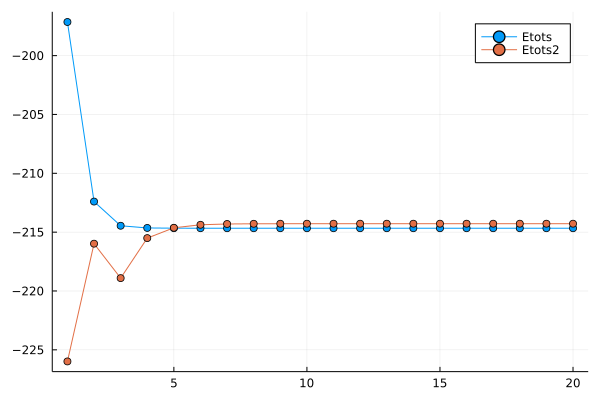

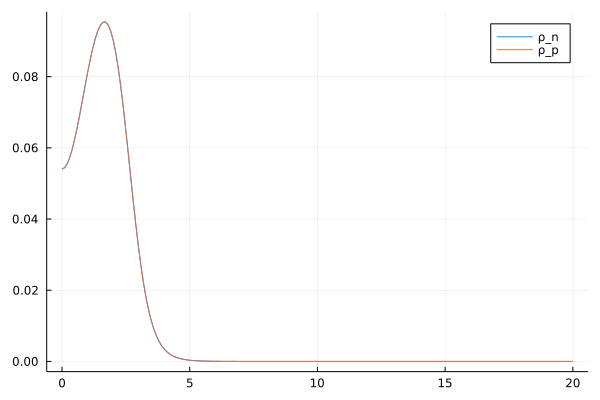

  0.140743 seconds (2.35 k allocations: 32.086 MiB)
E = -214.6670101104977
E₂ = -214.2821979945171

i = 1: 
spEs[i] = -38.07433512601245
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 2: 
spEs[i] = -38.07433512601245
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 3: 
spEs[i] = -24.379523629739175
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 4: 
spEs[i] = -24.379523629739175
occ[i] = 1.0
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 5: 
spEs[i] = -8.625651405063463
occ[i] = 0.2
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1


i = 6: 
spEs[i] = -8.625651405063463
occ[i] = 0.2
Δs[i] = 0.0
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2


i = 7: 
spEs[i] = -5.042813290528112
occ[i] = 0.0
Δs[i] = 0.0
qnums[i] = Mai

In [218]:
param = My.PhysicalParam(N=10,Z=10, Nr=200)
HF_calc(param; iter_max=20, show_result=true)

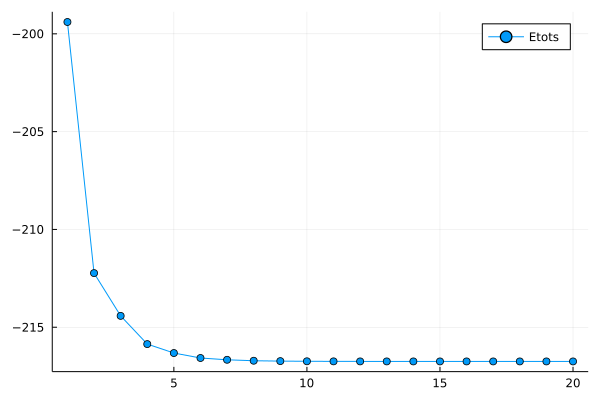

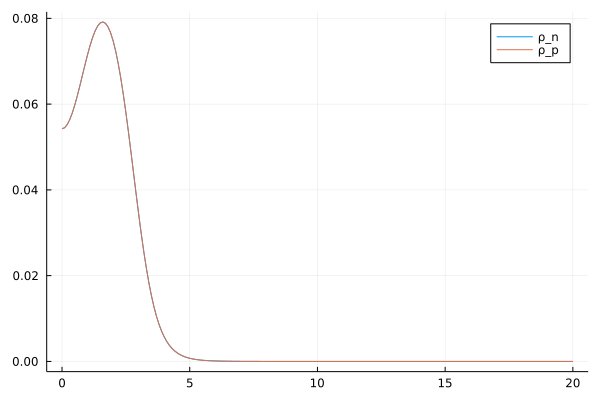

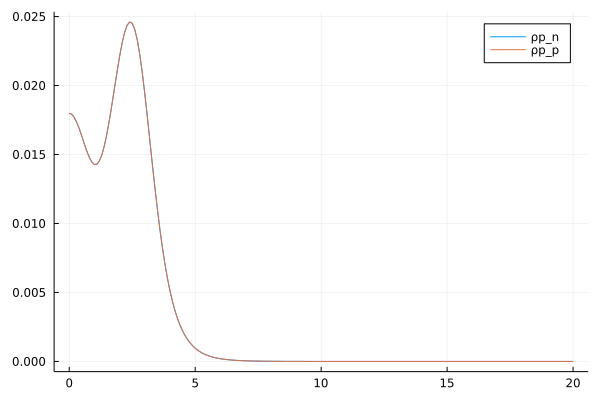

  0.099055 seconds (2.59 k allocations: 32.096 MiB)
E = -216.74618636708902

i = 1: 
spEs[i] = -31.854308287809598
occ[i] = 0.9994350747132709
Δs[i] = 1.147456822906382
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1


i = 2: 
spEs[i] = -31.854308287809598
occ[i] = 0.9994350747132709
Δs[i] = 1.147456822906382
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2


i = 3: 
spEs[i] = -19.376744079642872
occ[i] = 0.9923497051272665
Δs[i] = 2.0600118151302342
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1


i = 4: 
spEs[i] = -19.376744079642872
occ[i] = 0.9923497051272665
Δs[i] = 2.0600118151302342
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2


i = 5: 
spEs[i] = -5.773163135277247
occ[i] = 0.19624101845199138
Δs[i] = 2.566640982956771
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1


i = 6: 
spEs[i] = -5.773163135277247
occ[i] = 0.19624101845199138
Δs[i] = 2.5666409829

In [219]:
param = My.PhysicalParam(N=10,Z=10, Nr=200)
HFBCS_calc(param; iter_max=20, show_result=true)